### Charger et compiler le projet ecm_rules
___

In [3]:
# Verifier qu'on se trouve dans le répertoire PhysiCell
!ls

InitialConditioncreator.ipynb  sbi_project_ecm.ipynb
NN			       sbi_project_ecm_rules.ipynb
PhysiCell		       sbi_toolbox.ipynb
README.md		       simulation_POC_1_param_prolif.ipynb
env			       simulation_POC_adhesion_repulsion.ipynb
ic_3D.py		       simulation_POC_rules_prolif.ipynb
inference.pkl		       simulator_3_pop_proportion.ipynb
output.png		       simulator_invasion.ipynb
requirements.txt	       simulator_leader_cell_path.ipynb
sbi-logs		       simulatorwrap.ipynb


In [4]:
# Sinon, se déplacer dans le répertoire PhysiCell
import os
os.chdir("PhysiCell")

In [5]:
# Ici, changer et mettre le bon nom du projet
project_name = "ecm_rules"

In [9]:
!make clean
!make data-cleanup
!make reset
!make load PROJ=$project_name
!make

rm -f *.o
rm -f project*


rm -rf ./output
mkdir ./output
touch ./output/empty.txt
rm -f *.cpp 
cp ./sample_projects/Makefile-default Makefile 
rm -f ./custom_modules/*
touch ./custom_modules/empty.txt 
touch ALL_CITATIONS.txt 
touch ./core/PhysiCell_cell.cpp
rm ALL_CITATIONS.txt 
cp ./config/PhysiCell_settings-backup.xml ./config/PhysiCell_settings.xml 
touch ./config/empty.csv
rm -f ./config/*.csv
echo "Loading project from ecm_rules ... "
Loading project from ecm_rules ... 
cp ./user_projects/ecm_rules/main.cpp .
cp ./user_projects/ecm_rules/Makefile .
cp ./user_projects/ecm_rules/config/* ./config/ 
cp ./user_projects/ecm_rules/custom_modules/* ./custom_modules/ 
g++  -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_vector.cpp 
g++  -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_mesh.cpp 
g++  -march=native  -O3 -fomit-frame-pointer -mfpmath=both -fopenmp -m64 -std=c++11  -c ./BioFVM/BioFVM_microenvironment.

### Modifier le projet
___

In [17]:
# Si on souhaite ouvrir l'interface du projet
# La ligne suivante est spécifique au projet ecm puisqu'on utilise studio_ecm plutôt que studio

!python3 studio/bin/studio_ecm.py -e project -c config/PhysiCell_settings.xml

args= Namespace(bare=False, three=False, tensor=False, skip_validate=False, nanohub=False, config='config/PhysiCell_settings.xml', exec='project')
unknown= []
exec_file exists
PhysiCellXMLCreator(): self.nanohub_flag=  False
  platform.system().lower()=linux, platform.machine()=x86_64
Could not parse application stylesheet
self.current_dir =  /home/aymeric/tumor-simulation/PhysiCell
self.studio_root_dir =  /home/aymeric/tumor-simulation/PhysiCell/studio
self.config_dir =  /home/aymeric/tumor-simulation/PhysiCell/config
got config_file= config/PhysiCell_settings.xml
studio: (default) self.config_file = /home/aymeric/tumor-simulation/PhysiCell/config/PhysiCell_settings.xml
studio: (default) self.tree = <xml.etree.ElementTree.ElementTree object at 0x7f254512eb90>
studio: (default) self.xml_root = <Element 'PhysiCell_settings' at 0x7f2545130ef0>
QLayout::addChildLayout: layout "" already has a parent
Could not parse stylesheet of object Config(0x564fd4b03f20)
studio.py: ---- FALSE nanohub_

In [11]:
# Sauvegarder les modifications réalisées dans user_projects
!make save PROJ=$project_name

echo "Saving project as ecm_rules ... "
Saving project as ecm_rules ... 
mkdir -p ./user_projects
mkdir -p ./user_projects/ecm_rules
mkdir -p ./user_projects/ecm_rules/custom_modules
mkdir -p ./user_projects/ecm_rules/config 
cp main.cpp ./user_projects/ecm_rules
cp Makefile ./user_projects/ecm_rules
cp VERSION.txt ./user_projects/ecm_rules
cp ./config/* ./user_projects/ecm_rules/config
cp ./custom_modules/* ./user_projects/ecm_rules/custom_modules


## SBI
___

In [6]:
import xml.etree.ElementTree as ET

def modify_xml_value(file_path, tag_path, new_value):
    tree = ET.parse(file_path)
    root = tree.getroot()
    element = root
    for tag in tag_path:
        element = element.find(tag)
        if element is None:
            print(f"Balise '{tag}' non trouvée dans le chemin spécifié.")
            return False
    element.text = str(new_value)
    tree.write(file_path, encoding="utf-8", xml_declaration=True)
    return True

In [7]:
import csv
def change_csv_value(csv_file_path, row_index, column_index, new_value):
    # Read the CSV file into a list of lists
    with open(csv_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        data = list(reader)
    # Update the value of the specified cell
    if 0 <= row_index < len(data) and 0 <= column_index < len(data[row_index]):
        data[row_index][column_index] = str(new_value)

        # Save the modified data to the CSV file
        with open(csv_file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerows(data)

    else:
        print(f"Invalid row index ({row_index}) or column index ({column_index})")


In [8]:
import xml.etree.ElementTree as ET

def get_agent_count(svg_file_path):
    # Parse the SVG file
    tree = ET.parse(svg_file_path)
    root = tree.getroot()
    
    # Define the namespace
    namespaces = {'svg': 'http://www.w3.org/2000/svg'}
    
    # Find all text elements
    text_elements = root.findall('.//svg:text', namespaces)
    
    # Iterate through text elements to find the one containing the agent count
    for elem in text_elements:
        if 'agents' in elem.text:
            # Extract the number of agents from the text
            agent_count = int(''.join(filter(str.isdigit, elem.text)))
            return agent_count
    
    # If no agent count was found, return None or raise an exception
    return None

In [15]:
import torch
import subprocess

def simulation(params):

    if len(params.shape) == 1:
        n = 1
        num_params = len(params)
    else:
        n, num_params = params.shape
    
    results = []
    
    for i in range(n):
        if n == 1:
            current_params = params
        else:
            current_params = params[i]

        # Liste des chemins XML et des noms de paramètres
        xml_paths = [
            ["cell_definitions", "cell_definition[@name='follower cell']", "phenotype", "motility", "speed"]
        ]

        csv_paths = [[0, 4], [5, 4]]

       
        for j in range(min(num_params, len(xml_paths))):
            modify_xml_value("config/PhysiCell_settings.xml", xml_paths[j], current_params[j].item())
        
        for j in range(min(num_params, len(csv_paths))):
            change_csv_value('./config/rules.csv', csv_paths[j][0], csv_paths[j][1],  current_params[len(xml_paths)+j].item())
        
        subprocess.run(["./project"], stdout=subprocess.DEVNULL)

        svg_filename = '/home/aymeric/tumor-simulation/PhysiCell/output/final.svg'
        agent_count = get_agent_count(svg_filename)
        results.append(torch.tensor(agent_count))

    results = torch.tensor(results)
    return results.flatten()

In [18]:
print(simulation(torch.tensor([0.2, 0.003, 2])))

tensor([143])


In [20]:
import torch
from sbi.inference import prepare_for_sbi

from sbi import utils as utils
from sbi import analysis as analysis


# Définir les bornes inférieures pour chaque dimension
low = torch.tensor([0, 0, 0])

# Définir les bornes supérieures pour chaque dimension
high = torch.tensor([1, 0.005, 3])

# Créer le a priori uniforme avec les bornes spécifiées
prior = utils.BoxUniform(low=low, high=high)

simulator, prior = prepare_for_sbi(simulation, prior)

In [21]:
from sbi.inference import SNPE

inference = SNPE(prior=prior)

In [22]:
from sbi.inference import simulate_for_sbi

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=15) # 15 simulations pour l'exemple

Running 15 simulations.:   0%|          | 0/15 [00:00<?, ?it/s]

Running 15 simulations.: 100%|██████████| 15/15 [01:56<00:00,  7.77s/it]


In [23]:
# On ajoute les simulations à l'objet inference
inference = inference.append_simulations(theta, x)

# On entraîne le réseau de neurones
density_estimator = inference.train()


 Neural network successfully converged after 61 epochs.

In [24]:
posterior = inference.build_posterior(density_estimator)

In [25]:
theta = torch.tensor([0.2, 0.003, 2]) # Paramètre de départ que l'on cherche à prédire
x_o = simulation(theta) # Résultat de la simulation pour le paramètre de départ

Drawing 10000 posterior samples: 10028it [00:00, 67209.56it/s]            


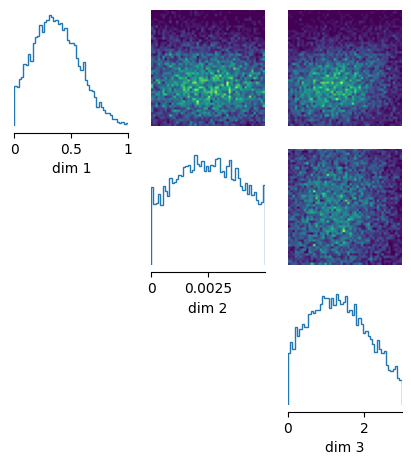

In [26]:
# On génère 10000 échantillons à partir du posterior (très rapide car on utilise un NN)
posterior_samples = posterior.sample((10000,), x=x_o) 

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 1], [0, 0.005], [0,3]], figsize=(5, 5) # bornes min et max pour chaque paramètre à changer
)